In [1]:
from __future__ import print_function
import pretty_midi
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# For putting audio in the notebook
import IPython.display
midi_data = pretty_midi.PrettyMIDI('G:/钢琴曲子/chopin/chpn_op23.mid')
# Print an empirical estimate of its global tempo
print(midi_data.instruments)
a = midi_data.instruments[0].get_piano_roll()


for instr_num in range (len(midi_data.instruments)):
    if not midi_data.instruments[instr_num].is_drum:
        instrument= (midi_data.instruments[instr_num])
        print (instrument)
print (instrument)

[Instrument(program=0, is_drum=False, name="Piano right"), Instrument(program=0, is_drum=False, name="Piano left")]
Instrument(program=0, is_drum=False, name="Piano right")
Instrument(program=0, is_drum=False, name="Piano left")
Instrument(program=0, is_drum=False, name="Piano left")


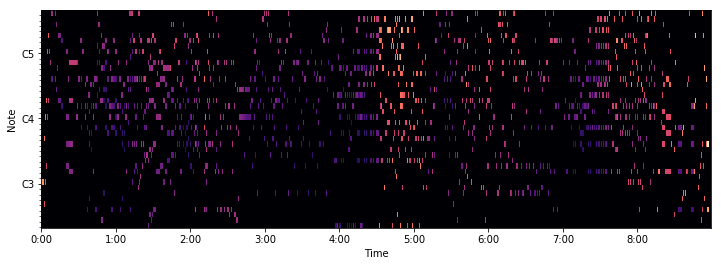

In [2]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],hop_length=1,
                             sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(12, 4))
plot_piano_roll(midi_data, 40,80)

删除通道10的音轨 删除鼓 也可统一音色 只需更改program即可

[Instrument(program=0, is_drum=False, name="Piano right"), Instrument(program=0, is_drum=False, name="Piano left")]


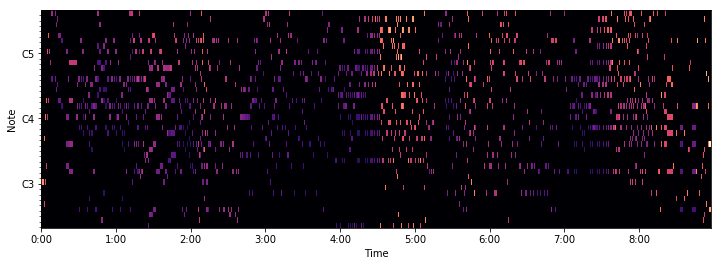

In [3]:
def deleteDrum(midi_data):
    new_midi = pretty_midi.PrettyMIDI()
    notes_velocity = []
    notes_pitch = []
    notes_start = []
    notes_end = []
    for instr_num in range (len(midi_data.instruments)):
        if not midi_data.instruments[instr_num].is_drum:
            instrument = (midi_data.instruments[instr_num])            
            program = instrument.program
            is_drum = instrument.is_drum
            name = instrument.name
            inst = pretty_midi.Instrument(program=program, is_drum=is_drum, name=name)
            new_midi.instruments.append(inst)
            for j in range (len(instrument.notes)):
                note = instrument.notes[j]
                inst.notes.append(pretty_midi.Note(note.velocity, note.pitch, note.start, note.end))
    return new_midi
#注 ：可将该新生成的midi写出来 midi.write即可
new_midi = deleteDrum(midi_data)
#打印新生成的midi         
print(new_midi.instruments)

plt.figure(figsize=(12, 4))
plot_piano_roll(new_midi, 40,80)

将pretty_midi对象转变成数组格式 方便数据处理

In [4]:
def get_train_data(new_midi):
    train_data = []
    for i in range (len(new_midi.instruments)):
        notes =[]
        for j in range (len(new_midi.instruments[i].notes)):
            note = new_midi.instruments[i].notes[j]
            #更改了note事件的参数位置
            notes.append(note.start)
            notes.append(note.end)
            notes.append(note.velocity)
            notes.append(note.pitch)
        a = np.array(notes)
        train_data.append(a)     
    return train_data
train_data=get_train_data(new_midi)
#type(train_data[2])


pitch%12 取模 化成十二平均律

def getMod(x):
    for i in range(len(x)):
        for j in range(len(x[i])):
            if (j%4==3):
                x[i][j]= x[i][j]%12
    return x
#train_data_12=getMod(train_data)
#train_data_12[2]
    

skyline算法 以保证每个音轨不存在复调 产生复调的满足以下条件：1.S1<=S2 2.E1>S2

In [5]:
#这是一段丑陋的代码 暂时不优化
def skyline(track):
    siz = len(track)-4
    i=0
    while(i!=siz):
        if ((track[i]<=track[i+4])&(track[i+1] > track[i+4])):
            if ((track[i+3]<track[i+7])):
                track[i+1] = track[i+4]
                
                if (track[i] == track[i+1]):
                    track=np.delete(track,i)                    
                    track=np.delete(track,i)
                    track=np.delete(track,i)
                    track=np.delete(track,i)                    
                    siz = siz-4
                i= -4
            else:
                track[i+4] = track[i+1]                    
                if (track[i+4] >= track[i+5]):                   
                    track=np.delete(track,i+4)                    
                    track=np.delete(track,i+4)
                    track=np.delete(track,i+4)
                    track=np.delete(track,i+4)
                    siz = siz-4                    
                i= -4    
        
        elif (track[i]>=track[i+4]):  
            track[i], track[i+4] = track[i+4], track[i] 
            track[i+1], track[i+5] = track[i+5], track[i+1] 
            track[i+2], track[i+6] = track[i+6], track[i+2] 
            track[i+3], track[i+7] = track[i+7], track[i+3] 
            i= -4
        i = i+4
    return track
#track=skyline(train_data_12[2])
#track
#elif (track[i+4]<track[i]):
    


    

给所有音轨使用skyline去除复调关系

In [6]:
def allSkyline(s):
    a = []
    for i in range(len(s)):
        a.append(skyline(s[i]))
    return a

simple_data = allSkyline(train_data)
simple_data
        

[array([1.81080625e-03, 2.17296750e+00, 9.00000000e+01, ...,
        5.37983098e+02, 1.17000000e+02, 5.50000000e+01]),
 array([1.81080625e-03, 2.17296750e+00, 7.40000000e+01, ...,
        5.37983098e+02, 9.50000000e+01, 4.30000000e+01])]

In [7]:
#初始化音高向量
h=np.zeros((len(simple_data),128),dtype = int)
h.shape

(2, 128)

取出音高求取音高分布

In [8]:
from collections import Counter
#先变为整型
def getPitchInt(a):
    s = []
    for j in range(len(a)):
        if (j%4==3):
            s.append(a[j]+1)
    n = np.array(s,dtype = int)

    return n
pitch_int = getPitchInt(simple_data[0])
print(Counter(pitch_int))


Counter({75: 143, 71: 102, 80: 96, 73: 94, 83: 88, 68: 74, 76: 70, 81: 64, 87: 61, 82: 60, 79: 57, 63: 57, 78: 55, 70: 54, 85: 53, 59: 44, 92: 40, 95: 39, 69: 38, 67: 38, 61: 37, 66: 30, 90: 30, 74: 29, 88: 28, 64: 27, 72: 26, 93: 26, 84: 24, 60: 23, 65: 22, 77: 22, 94: 22, 91: 22, 89: 19, 51: 19, 86: 19, 54: 17, 57: 16, 97: 13, 99: 13, 58: 11, 56: 11, 62: 10, 96: 10, 52: 9, 55: 7, 101: 7, 100: 6, 98: 5, 49: 4, 102: 4, 47: 4, 48: 3, 43: 2, 40: 2, 46: 2, 53: 2, 50: 1, 45: 1, 42: 1, 38: 1, 36: 1, 44: 1, 39: 1, 37: 1, 35: 1, 34: 1})


In [9]:
#统计音高出现次数
def getPitch(simple_data,h):
    s = []
    for i in range(1,129):
        for j in range (len(simple_data)):
             if ((j%4==3)&((simple_data[j]+1)==i)):
                h[i-1]=h[i-1]+1
    return h
h[0] = getPitch(simple_data[0],h[0])
print(simple_data[0])
h[0]


[1.81080625e-03 2.17296750e+00 9.00000000e+01 ... 5.37983098e+02
 1.17000000e+02 5.50000000e+01]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,
         2,   0,   1,   2,   1,   1,   2,   4,   3,   4,   1,  19,   9,
         2,  17,   7,  11,  16,  11,  44,  23,  37,  10,  57,  27,  22,
        30,  38,  74,  38,  54, 102,  26,  94,  29, 143,  70,  22,  55,
        57,  96,  64,  60,  88,  24,  53,  19,  61,  28,  19,  30,  22,
        40,  26,  22,  39,  10,  13,   5,  13,   6,   7,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [10]:
#生成音高向量 值为每个音符在不同音轨中出现的次数

def pitchVec(a,h):
    for i in range(len(a)):
        w = getPitchInt(a[i])
        h[i] = getPitch(a[i],h[i])
    return h

h= pitchVec(simple_data,h)
k = []
for j in range(len(h)):
    k.append(j)
labels= np.array(k)
labels  
h

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,   2,   2,   2,   2,   2,
          4,   0,   2,   4,   2,   2,   4,   8,   6,   8,   2,  38,  18,
          4,  34,  14,  22,  32,  22,  88,  46,  74,  20, 114,  54,  44,
         60,  76, 148,  76, 108, 204,  52, 188,  58, 286, 140,  44, 110,
        114, 192, 128, 120, 176,  48, 106,  38, 122,  56,  38,  60,  44,
         80,  52,  44,  78,  20,  26,  10,  26,  12,  14,   8,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   3,   0,   2,  12,   2,  10,   2,  48,
         40,  23,  14,  10,  47,   6,  13,  95,  18,  33,  1

h_i 第i个音轨的音高分布向量

h_average 平均音高分布向量 =（h_1_averang,...,h_12_averang）

h_i_average 音符为i 在每个音轨中出现的平均次数 T为音轨数 h_i_average = h_k(1——T)_i（累加）/T 

h_wi_average 音符为i 在每个音轨中出现的次数的加权平均值   h_wi_average = h_k(1——T)_i*fk

h_w_average 加权平均分布   

fk 某个音轨音符数/音符总数

In [11]:
h_average= np.average(h,axis=0)
h_average

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   1.5,   0. ,   2. ,   7. ,   2. ,
         6. ,   2. ,  25. ,  22. ,  11.5,   8. ,   7. ,  24.5,   4. ,
         8.5,  51.5,  12. ,  20.5,   6.5,  55. ,  53.5,  17.5,  44. ,
        13.5,  50.5,  36. ,  27. ,  85. ,  34. ,  62. ,  18.5, 101.5,
        63.5,  41. ,  50. ,  54. ,  95. ,  48.5,  66. , 109. ,  26. ,
        97. ,  29. , 148. ,  73. ,  22.5,  56. ,  57.5,  96.5,  64.5,
        60. ,  88.5,  24. ,  54. ,  19. ,  63. ,  30. ,  19. ,  30. ,
        22. ,  40. ,  26. ,  22. ,  39. ,  10. ,  13. ,   5. ,  13. ,
         6. ,   7. ,   4. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ]

In [12]:
#求fk pitch_num of 音轨i /all pitchs
def get_fk(h):
    ff=[]
    m=0
    pitchsum = np.sum(h)
    print(pitchsum)
    for i in range(len(simple_data)):
        m=(np.sum(h[i]))/pitchsum
        ff.append(m)
    fk= np.array(ff)
    return fk
fk = get_fk(h)
fk

5222


array([0.73535044, 0.26464956])

In [13]:
h_w_average= np.average(h, axis = 0 ,weights = fk)
h_w_average

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.79394868,
         0.        ,   2.        ,   4.6464956 ,   2.        ,
         4.11719648,   2.        ,  14.17387974,  13.52738414,
         6.08693987,   5.17579471,   5.58789736,  13.90923018,
         3.05859824,   6.38184604,  31.02451168,   9.17579471,
        14.61623899,   4.38184604,  46.99808502,  36.79011873,
        11.14553811,  39.29299119,  13.73535044,  37.08502489,
        34.11719648,  24.6464956 ,  86.41210264,  39.64841057,
        67.64841057,  19.20605132, 107.38376101,  59.02

In [14]:
# 计算h_average和h_w_average向量之间的欧氏距离，欧氏距离计算如下： 
dist1 = np.sqrt(np.sum(np.square(h_w_average- h_average)))
print(dist1)
dist2 = np.linalg.norm(h_w_average- h_average)
dist2

149.28343554694226


149.28343554694226

In [15]:
#层次聚类终止算法的阈值t
t = dist1/2
t

74.64171777347113

In [16]:
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster  
df = pd.DataFrame(h, index = labels)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


{'icoord': [[5.0, 5.0, 15.0, 15.0]],
 'dcoord': [[0.0, 634.3027668235414, 634.3027668235414, 0.0]],
 'ivl': [0, 1],
 'leaves': [0, 1],
 'color_list': ['b']}

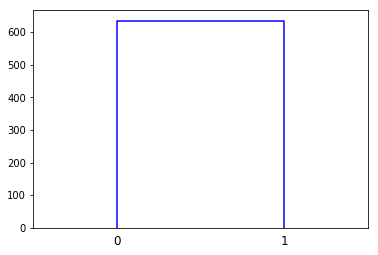

In [17]:
Z = hierarchy.linkage(df, method ='ward',metric='euclidean')
hierarchy.dendrogram(Z,labels = df.index)

可裁剪

In [18]:
label = cluster.hierarchy.cut_tree(Z,height=t)
label = label.reshape(label.size,)
label

array([0, 1])

In [19]:
Z

array([[  0.        ,   1.        , 634.30276682,   2.        ]])

   0    1    2    3    4    5    6    7    8    9   ...   118  119  120  121  \
0    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   122  123  124  125  126  127  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  

[2 rows x 128 columns]
           row label1  row label2    distance  no. of items in clust.
cluster 1         0.0         1.0  634.302767                     2.0


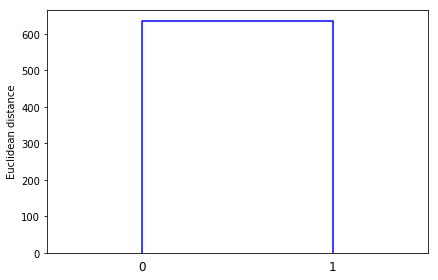

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


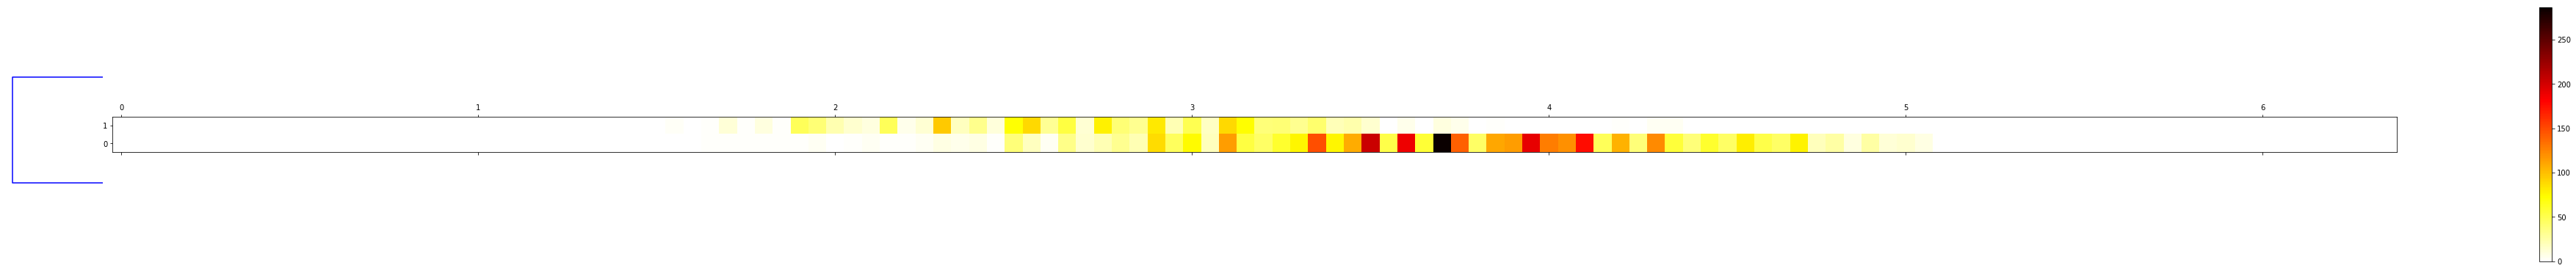

In [20]:
#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
#np.random.seed(123)
#X=np.random.random_sample([5,3])*10
#层次聚类树
#df = pd.DataFrame(X,columns=variables,index=labels)

df = pd.DataFrame(h, index = labels)
print (df)
#计算距离关联矩阵，两两样本间的欧式距离
#row_dist = pd.DataFrame(squareform(pdist(df,metric='euclidean')),columns=labels,index=labels)
#print (row_dist)
#print (help(linkage))
row_clusters = linkage(pdist(df,metric='euclidean'),method='ward')#使用抽秘籍距离矩阵
#row_clusters = linkage(df.values,method='complete',metric='euclidean')
print (pd.DataFrame(row_clusters,columns=['row label1','row label2','distance','no. of items in clust.'],index=['cluster %d'%(i+1) for i in range(row_clusters.shape[0])]))
#层次聚类树
row_dendr = dendrogram(row_clusters,labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()
#层次聚类热度图
fig =plt.figure(figsize=(9,8))
axd =fig.add_axes([0.08,0.16,0.2,0.5])
row_dendr = dendrogram(row_clusters,orientation='left')
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
axm = fig.add_axes([0.3,0.1,6.0,0.6])
cax = axm.matshow(df_rowclust,interpolation='nearest',cmap='hot_r')
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels(['']+list(df_rowclust.columns))
axm.set_yticklabels(['']+list(df_rowclust.index))
plt.show()
 
#凝聚层次聚类，应用对层次聚类树剪枝
ac=AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='complete')
#acc=ac.fit(h)
#label = ac.fit_predict(h)
#print ('cluster labels:%s'%label)

p(i)  音符i在该轨出现的频率
- 求和（1-12）p(i)log12p(i)

In [21]:
#xi=pi(某音块平均音高) +128*calc_ent(ci)  ci 某音轨
import math
def calc_ent(x):
    track_sum=np.sum(x)
    ent = 0.0
    for i in range(len(x)):
        p = x[i]/track_sum
        if (p!=0) :
            logp=math.log(p,128)
            ent -= p*logp
    return ent
c1= calc_ent(h[1])
c1


0.7121216928959616

In [22]:
def calc_xi(h):
    xi = []
    for i in range(len(h)):
         #计算平均音高
        track_average = np.average(h[i])
        xi.append(track_average+128*calc_ent(h[i]))
    xi_ary = np.array(xi)
    return xi_ary
xi = calc_xi(h)
        
dfent = pd.DataFrame(xi, index = label)
dfent

,0
0,127.980409
1,101.948452


选出每簇综合显著度（xi）最大的音轨为代表

In [23]:
al = dfent.loc[1]
aa =al[0].tolist()
maxx = np.max(aa)
maxx

101.94845169068309

In [24]:
def get_xi_max(df):      #求出每个簇的代表音轨
    xi = []
    
    for i in range(len(df)):
        x_max = np.empty([2],dtype=float)
        a_label = df.loc[df.index[i]]     #提取某一行的行标签 并把行标签相同的聚集在一起
        a_list = a_label[0].tolist()       #转为列表
        x_max[0] = np.max(a_list)
        if x_max[0] == df.values[i][0]:
            x_max[1] = i
        else:
            x_max[1] = -1
        xi.append(x_max)
    xi_ary = np.array(xi)
    return xi_ary
xi_max = get_xi_max(dfent)
xi_max
        
        
            
            

array([[127.98040901,   0.        ],
       [101.94845169,   1.        ]])

取出每簇的代表音轨后，对所有音轨进行skyline算法进行整合 提出主旋律

In [25]:
#从原有的音轨数组中提出代表音轨 合并成一个音轨 等待时间排序并进行skyline处理
def get_main_melody(xi_max,simple_data):
    x = []
    for i in range (len(simple_data)):
        if xi_max[i][1] >= 0:
            print(i)
            x.append(simple_data[i])    #取出代表音轨
    main_array = np.array(x)          #存为数组
    main_flat = [y for x in main_array for y in x]    #扁平化
    main_melody = np.array(main_flat,dtype = float)
    return main_melody
main_melody = get_main_melody(xi_max,simple_data)
main_melody

0
1


array([1.81080625e-03, 2.17296750e+00, 9.00000000e+01, ...,
       5.37983098e+02, 9.50000000e+01, 4.30000000e+01])

In [26]:
#（1，n）reshape为（m,4） m=n/4
def main_reshape(main_melody):
    n = len(main_melody)
    print(n)
    m=int (n/4)
    main_re_melody = main_melody.reshape(-1,4)
    return main_re_melody
main_re_melody = main_reshape(main_melody)
print(main_re_melody.shape)
#main_re_melody

13208
(3302, 4)


In [27]:
dff = pd.DataFrame(main_re_melody)
import copy
dff

,0,1,2,3
0,0.001811,2.172967,90.0,48.0
1,2.172967,2.580909,79.0,51.0
2,2.580909,2.970519,83.0,56.0
3,2.970519,3.375925,76.0,58.0
4,3.375925,3.763022,83.0,60.0
5,3.763022,4.154330,75.0,56.0
6,4.154330,4.536496,76.0,63.0
7,4.536496,4.921111,72.0,70.0
8,4.921111,5.313268,73.0,72.0
9,5.313268,5.713268,68.0,68.0


排序并进行skyline处理 提出最终主旋律

In [28]:
def QuickSort(alist, start, end):
    mid = np.empty([4])
    
    # 建立递归终止条件
    if start >= end:
        return
 
    # low为序列左边要移动的游标
    low = start
    # last为序列右边要移动的游标
    last = end
 
    # 将起始元素设为要寻找位置的基准元素
    mid = copy.deepcopy(alist[start])
    mid_num = alist[start][0] #3.6115   3.992
 
    while low < last:
        # 当low与last未重合，并且比基准元素要大，就将游标向左移动
        while low < last and alist[last][0] >= mid_num:
            last -= 1
        # 如果比基准元素小，就跳出循环，并且把其放在基准元素左边
        alist[low] = alist[last]
 
        # 当low与last未重合，并且比基准元素要小，就将游标向右移动
        while low < last and alist[low][0] < mid_num:
            low += 1
        # 如果比基准元素大，就跳出循环，并且把其放在基准元素右边
        alist[last] = alist[low]
  
    # 当low与last相等，就是mid_num的排序位置
    alist[low] = mid 
 
    # 然后对排序好的元素左右两边的序列进行递归
    QuickSort(alist, start, low-1) # 对左边的序列进行递归
    QuickSort(alist, low+1, end) # 对右边的序列进行递归
    
QuickSort(main_re_melody,0,len(main_re_melody)-1)

In [29]:
dffff = pd.DataFrame(main_re_melody)
dffff

,0,1,2,3
0,0.001811,2.172967,90.0,48.0
1,0.001811,2.172967,74.0,36.0
2,2.172967,2.580909,79.0,51.0
3,2.172967,2.580909,66.0,39.0
4,2.580909,2.970519,70.0,44.0
5,2.580909,2.970519,83.0,56.0
6,2.970519,3.375925,76.0,58.0
7,2.970519,3.375925,64.0,46.0
8,3.375925,3.763022,83.0,60.0
9,3.375925,3.763022,70.0,48.0


In [30]:
#去掉相同开始时间的音符
def trry(x):
    i =0
    while i <len(x):
        j = 0
        while j < len(x):

            if (x[i][0] == x[j][0]):
                if (x[i][3] < x[j][3]):
                    if(x[i][1] <=x[j][1]):
                        x[i][1] = x[i][0]
                    else:
                        x[i][0]=x[j][1]
                if (x[i][3] > x[j][3]):
                    if(x[i][1]<x[j][1]):
                        x[j][0] = x[i][1]
                    else:
                        x[j][1]=x[j][0]
                if(x[i][3]==x[j][3] and i!=j):
                    if(x[i][1]<=x[j][1]):
                        x[i][1]=x[i][0]
                    else:
                        x[j][1]=x[j][0]
            j+=1
        i+=1
    i=0
    b=0
    while i < len(x):
        i=i-b
        b=0
        if (x[i][0]>=x[i][1]):
            x=np.delete(x,i,axis=0)
            b+=1
        i+=1
    return x
sss = trry(main_re_melody)
sss

array([[1.81080625e-03, 2.17296750e+00, 9.00000000e+01, 4.80000000e+01],
       [2.17296750e+00, 2.58090900e+00, 7.90000000e+01, 5.10000000e+01],
       [2.58090900e+00, 2.97051950e+00, 8.30000000e+01, 5.60000000e+01],
       ...,
       [5.34816430e+02, 5.35233097e+02, 1.13000000e+02, 7.90000000e+01],
       [5.35649764e+02, 5.36483098e+02, 1.08000000e+02, 9.40000000e+01],
       [5.36483098e+02, 5.37983098e+02, 1.17000000e+02, 5.50000000e+01]])

In [31]:
#再进行一次排序
QuickSort(sss,0,len(sss)-1)

In [32]:
pd.set_option('display.max_columns',4) #a就是你要设置显示的最大列数参数
pd.set_option('display.max_rows',250) #b就是你要设置显示的最大的行数参数

dffffs = pd.DataFrame(sss)
dffffs


,0,1,2,3
0,0.001811,2.172967,90.0,48.0
1,2.172967,2.580909,79.0,51.0
2,2.580909,2.970519,83.0,56.0
3,2.970519,3.375925,76.0,58.0
4,3.375925,3.763022,83.0,60.0
5,3.763022,4.154330,75.0,56.0
6,4.154330,4.536496,76.0,63.0
7,4.536496,4.921111,72.0,70.0
8,4.921111,5.313268,73.0,72.0
9,5.313268,5.713268,68.0,68.0


In [33]:


#扁平化便于skyline
sms = sss.flatten()
sms
smsss = skyline(sms)
#化为[n,4]
smss = main_reshape(smsss)

dn = pd.DataFrame(smss)
dn

8464


,0,1,2,3
0,0.001811,2.172967,90.0,48.0
1,2.172967,2.580909,79.0,51.0
2,2.580909,2.970519,83.0,56.0
3,2.970519,3.375925,76.0,58.0
4,3.375925,3.763022,83.0,60.0
5,3.763022,4.154330,75.0,56.0
6,4.154330,4.536496,76.0,63.0
7,4.536496,4.921111,72.0,70.0
8,4.921111,5.313268,73.0,72.0
9,5.313268,5.713268,68.0,68.0


主旋律扁平化 然后转回prettymidi对象 实现时间转tick

[Instrument(program=0, is_drum=False, name="main")]


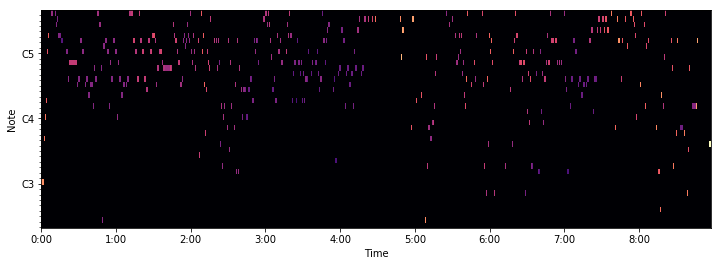

In [34]:
def back_to_Midi(ss):
    new_midi = pretty_midi.PrettyMIDI()
    notes_velocity = []
    notes_pitch = []
    notes_start = []
    notes_end = []
    program = 0
    is_drum = False
    name = 'main'
    inst = pretty_midi.Instrument(program=program, is_drum=is_drum, name=name)
    new_midi.instruments.append(inst)
    for i in range (len(ss)):                            
            notes_velocity = int (ss[i][2])
            notes_pitch = int (ss[i][3])
            notes_start = float (ss[i][0])
            notes_end = float (ss[i][1])
            inst.notes.append(pretty_midi.Note(notes_velocity, notes_pitch, notes_start, notes_end))
          #  print(new_midi.instruments[0].notes)
    return new_midi
#注 ：可将该新生成的midi写出来 midi.write即可
new = back_to_Midi(smss)
#打印新生成的midi         
print(new.instruments)

plt.figure(figsize=(12, 4))
plot_piano_roll(new,40,80)

In [36]:
#写下新的midi
new.write('cnew.mid')

In [37]:
#转tick
def time_To_tick(new):
    
    solo = []
    rhy = 0
    for i in range(len(new.instruments[0].notes)):
        note = new.instruments[0].notes[i]
        tick1 = new.time_to_tick(note.start)
        tick2 = new.time_to_tick(note.end)
        rhy= round((tick2-tick1)*4/120)
        if((rhy>4) & (rhy<8)):
            rhy = 6
        if(note.pitch<59):
            solo.append((note.pitch)-59)
        else:
            solo.append((note.pitch)%59)
        solo.append(rhy)
    asolo = np.array(solo)
    asolo1=asolo.reshape(int(len(asolo)/2),2)
    
    return asolo1
asolo = time_To_tick(new)     


In [38]:
def to_txt(x):
    i =0
    j=0
    lim=3
    b=1
    c=lim-len(x)%lim
    while i <len(x):
        a=str(x[i][0])+'('+str(x[i][1])+')'+' '
        if(i!=0):
            b=i%lim
        if (b==0):
            with open('14.txt', 'a')as file_handle:
                file_handle.write('\n')
                file_handle.write(a)
        else:
            with open('14.txt', 'a')as file_handle:
                file_handle.write(a)

        i+=1
    while j<c:
        with open('14.txt', 'a')as file_handle:
            file_handle.write('1(10)')
        j+=1
    with open('14.txt', 'a')as file_handle:
        file_handle.write('E')
to_txt(asolo)
